In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import isoweek
import os.path

In [2]:
data_url = "https://www.sentiweb.fr/datasets/incidence-PAY-7.csv"

In [3]:
raw_data = pd.read_csv(data_url, skiprows=1)
raw_data

week  indicator    inc  inc_low  inc_up  inc100  inc100_low  \
0     202115          7  11536     7684   15388      17          11   
1     202114          7  11197     7994   14400      17          12   
2     202113          7   9714     6289   13139      15          10   
3     202112          7  11520     8415   14625      17          12   
4     202111          7   9386     6678   12094      14          10   
5     202110          7   9056     6452   11660      14          10   
6     202109          7  10988     7938   14038      17          12   
7     202108          7  11281     8361   14201      17          13   
8     202107          7  13561    10315   16807      21          16   
9     202106          7  13401     9810   16992      20          15   
10    202105          7  12210     8988   15432      18          13   
11    202104          7  12026     8826   15226      18          13   
12    202103          7   8913     6375   11451      13           9   
13    202102          7   7795     5430   10160      12           8   
14    202101          7  10525     7750   13300      16          12   
15    202053          7  11978     8406   15550      18          13   
16    202052          7  12012     8285   15739      18          12   
17    202051          7  10564     7574   13554      16          11   
18    202050          7   7063     4744    9382      11           7   
19    202049          7   5026     3145    6907       8           5   
20    202048          7   6683     4312    9054      10           6   
21    202047          7   4999     2963    7035       8           5   
22    202046          7   3752     1963    5541       6           3   
23    202045          7   3696     2016    5376       6           3   
24    202044          7   4391     2375    6407       7           4   
25    202043          7   4376     2505    6247       7           4   
26    202042          7   4000     1979    6021       6           3   
27    202041          7   3961     2099    5823       6           3   
28    202040          7   2078      675    3481       3           1   
29    202039          7   1049      237    1861       2           1   
...      ...        ...    ...      ...     ...     ...         ...   
1555  199126          7  17608    11304   23912      31          20   
1556  199125          7  16169    10700   21638      28          18   
1557  199124          7  16171    10071   22271      28          17   
1558  199123          7  11947     7671   16223      21          13   
1559  199122          7  15452     9953   20951      27          17   
1560  199121          7  14903     8975   20831      26          16   
1561  199120          7  19053    12742   25364      34          23   
1562  199119          7  16739    11246   22232      29          19   
1563  199118          7  21385    13882   28888      38          25   
1564  199117          7  13462     8877   18047      24          16   
1565  199116          7  14857    10068   19646      26          18   
1566  199115          7  13975     9781   18169      25          18   
1567  199114          7  12265     7684   16846      22          14   
1568  199113          7   9567     6041   13093      17          11   
1569  199112          7  10864     7331   14397      19          13   
1570  199111          7  15574    11184   19964      27          19   
1571  199110          7  16643    11372   21914      29          20   
1572  199109          7  13741     8780   18702      24          15   
1573  199108          7  13289     8813   17765      23          15   
1574  199107          7  12337     8077   16597      22          15   
1575  199106          7  10877     7013   14741      19          12   
1576  199105          7  10442     6544   14340      18          11   
1577  199104          7   7913     4563   11263      14           8   
1578  199103          7  15387    10484   20290      27          18   
1579  199102          7  16277  

Y a-t-il des valeurs manquantes ? Apparemment non !

In [4]:
raw_data[raw_data.isnull().any(axis=1)]

Empty DataFrame
Columns: [week, indicator, inc, inc_low, inc_up, inc100, inc100_low, inc100_up, geo_insee, geo_name]
Index: []

In [5]:
data = raw_data.copy()

Nos données utilisent une convention inhabituelle: le numéro de
semaine est collé à l'année, donnant l'impression qu'il s'agit
de nombre entier. C'est comme ça que Pandas les interprète.
  
Un deuxième problème est que Pandas ne comprend pas les numéros de
semaine.  Il faut lui fournir les dates de début et de fin de
semaine. Nous utilisons pour cela la bibliothèque `isoweek`.

Comme la conversion des semaines est devenu assez complexe, nous
écrivons une petite fonction Python pour cela. Ensuite, nous
l'appliquons à tous les points de nos donnés. Les résultats vont
dans une nouvelle colonne 'period'.

In [6]:
def convert_week(year_and_week_int):
    year_and_week_str = str(year_and_week_int)
    year = int(year_and_week_str[:4])
    week = int(year_and_week_str[4:])
    w = isoweek.Week(year, week)
    return pd.Period(w.day(0), 'W')

data['period'] = [convert_week(yw) for yw in data['week']]

Il reste deux petites modifications à faire.

Premièrement, nous définissons les périodes d'observation
comme nouvel index de notre jeux de données. Ceci en fait
une suite chronologique, ce qui sera pratique par la suite.

Deuxièmement, nous trions les points par période, dans
le sens chronologique.

In [7]:
sorted_data = data.set_index('period').sort_index()

Nous vérifions la cohérence des données. Entre la fin d'une période et
le début de la période qui suit, la différence temporelle doit être
zéro, ou au moins très faible. Nous laissons une "marge d'erreur"
d'une seconde.

Ceci s'avère tout à fait juste, pas de problème à noter !

In [9]:
periods = sorted_data.index
for p1, p2 in zip(periods[:-1], periods[1:]):
    delta = p2.to_timestamp() - p1.end_time
    if delta > pd.Timedelta('1s'):
        print(p1, p2)

Un premier regard sur les données !

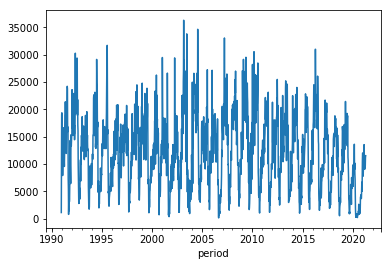

In [10]:
sorted_data['inc'].plot()

Zoom sur les dernières années : on voit un creux au moment des vacances d'été, quand les classes sont fermées !

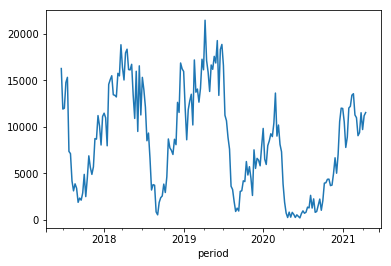

In [11]:
sorted_data['inc'][-200:].plot()

Début de chaque période le 1er septembre. L'année 1990 est incomplète, donc on commence l'analyse en 1991.

In [14]:
first_september_week = [pd.Period(pd.Timestamp(y, 9, 1), 'W')
                     for y in range(1991,
                                    sorted_data.index[-1].year)]

En partant de cette liste des semaines qui contiennent un 1er septembre, nous obtenons nos intervalles d'environ un an comme les périodes entre deux semaines adjacentes dans cette liste. Nous calculons les sommes des incidences hebdomadaires pour toutes ces périodes.

Nous vérifions également que ces périodes contiennent entre 51 et 52 semaines, pour nous protéger contre des éventuelles erreurs dans notre code.

In [15]:
year = []
yearly_incidence = []
for week1, week2 in zip(first_september_week[:-1],
                        first_september_week[1:]):
    one_year = sorted_data['inc'][week1:week2-1]
    assert abs(len(one_year)-52) < 2
    yearly_incidence.append(one_year.sum())
    year.append(week2.year)
yearly_incidence = pd.Series(data=yearly_incidence, index=year)

Incidences annuelles :

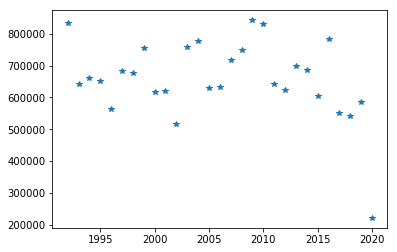

In [16]:
yearly_incidence.plot(style='*')

In [17]:
yearly_incidence.sort_values()

2020    221186
2002    516689
2018    542312
2017    551041
1996    564901
2019    584066
2015    604382
2000    617597
2001    619041
2012    624573
2005    628464
2006    632833
2011    642368
1993    643387
1995    652478
1994    661409
1998    677775
1997    683434
2014    685769
2013    698332
2007    717352
2008    749478
1999    756456
2003    758363
2004    777388
2016    782114
2010    829911
1992    832939
2009    842373
dtype: int64

Remarque : le minimum est atteint en 2020 à cause de la fermeture des classes. Mais le MOOC ayant été créé avant, le minimum attendu dans les réponses est celui de 2002 !